In [1]:
!pip install pyspark
# Alternatively, if you want to install a specific version of pyspark:
#!pip install pyspark==3.2.1 

     |████████████████████████████████| 281.4 MB 26 kB/s 
     |████████████████████████████████| 198 kB 29.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=2c972ee120f46dfbad970ef97a22d3912f1ab975b4eefe9a083ea365c0fa682f
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [2]:
from tqdm import tqdm

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

from pyspark.ml.feature import OneHotEncoder, StringIndexer

# Basic libreries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pre-processing phase
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Features Importance
from sklearn.inspection import permutation_importance

# Model
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Hyper-Parameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score

# Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
# Create the session
conf = SparkConf().set("spark.ui.port", "4050").set('spark.executor.memory', '4G').set('spark.driver.memory', '45G').set('spark.driver.maxResultSize', '10G')

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [4]:
spark

In [5]:
GDRIVE_DIR = "/content/gdrive" # Your own mount point on Google Drive
GDRIVE_HOME_DIR = GDRIVE_DIR + "/My Drive" # Your own home directory
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR +  "/Sapienza/Primo Anno/Big Data Computing/Project"

# Point Colaboratory to our Google Drive
from google.colab import drive

drive.mount(GDRIVE_DIR, force_remount=True)

DATASET_URL = "https://raw.githubusercontent.com/AndreaBe99/big-data-project/main/data/dataframe.csv"
GDRIVE_DATASET_FILE = GDRIVE_DATA_DIR + "/" + DATASET_URL.split("/")[-1]

Mounted at /content/gdrive


In [6]:
import requests

"""
This function downloads a file from a specific URL directly to Google Drive.
"""
def get_data(dataset_url, dest, chunk_size=1024):
  response = requests.get(dataset_url, stream=True)
  if response.status_code == 200: # Test if everything went ok
    with open(dest, "wb") as file:
      for block in response.iter_content(chunk_size=chunk_size): 
        if block: 
          file.write(block)

In [7]:
print("Retrieving dataset from URL: {} ...".format(DATASET_URL))
get_data(DATASET_URL, GDRIVE_DATASET_FILE)
print("Dataset successfully retrieved and stored at: {}".format(GDRIVE_DATASET_FILE))

Retrieving dataset from URL: https://raw.githubusercontent.com/AndreaBe99/big-data-project/main/data/dataframe.csv ...
Dataset successfully retrieved and stored at: /content/gdrive/My Drive/Sapienza/Primo Anno/Big Data Computing/Project/dataframe.csv


In [51]:
spotify_tracks = spark.read.load(GDRIVE_DATASET_FILE, 
                           format="csv", 
                           sep=";", 
                           inferSchema="true", 
                           header="true")

In [52]:
# spotify_tracks = spotify_tracks.to_pandas_on_spark()
pd.set_option('display.max_columns', None)
spotify_tracks = spotify_tracks.toPandas()

In [10]:
spotify_tracks.head()
# spotify_tracks.show(n=5, truncate=False)

,id,track_name,track_explicit,track_popularity,album_name,album_release_date,album_release_date_precision,artist_name,audio_avg_pitches,audio_avg_timbre,audio_acousticness,audio_danceability,audio_duration_ms,audio_energy,audio_instrumentalness,audio_key_1,audio_liveness,audio_loudness,audio_mode_1,audio_speechiness,audio_tempo,audio_time_signature,audio_valence,track_uri,track_genre
0,2dLLR6qlu5UJ5gk0dKz0h3,Royals,False,76,Pure Heroine,2013-09-27,day,Lorde,"[0.6041831187410588, 0.6443476394849783, 0.480...","[43.592423462088746, -4.162974248927038, -39.6...",121.00,674.00,190185,428.0,0.000000,7,132.0,-9504.0,1,122.0000,84878.0,4,337.0,spotify:track:2dLLR6qlu5UJ5gk0dKz0h3,acoustic
1,7AYoXqCtME90flUOpBJM7i,Society,False,0,Music For The Motion Picture Into The Wild,2007-12-17,day,Eddie Vedder,"[0.13272636815920405, 0.22224875621890575, 0.3...","[42.11574378109453, -49.73179477611938, -35.21...",896.00,0.64,236307,329.0,0.000536,11,113.0,-10844.0,0,0.0323,80687.0,4,295.0,spotify:track:7AYoXqCtME90flUOpBJM7i,acoustic
2,2bbhyUWJ5VjdfI3P4PRLu2,Samson,False,47,Begin to Hope (Special Edition),2006-06-13,day,Regina Spektor,"[0.14223992322456813, 0.258769673704415, 0.106...","[42.3769654510556, -30.21842034548948, 3.53678...",862.00,0.49,189507,193.0,0.000010,11,113.0,-9544.0,1,0.0421,89154.0,4,184.0,spotify:track:2bbhyUWJ5VjdfI3P4PRLu2,acoustic
3,7zkLpY72g6lKQbiHDqri1S,Sunrise,False,69,Feels Like Home,2004-01-01,day,Norah Jones,"[0.39770789473684215, 0.38362500000000016, 0.2...","[39.24825789473678, -103.68762368421064, -58.4...",941.00,526.00,200627,299.0,97.000000,8,106.0,-13797.0,1,31.0000,156848.0,4,679.0,spotify:track:7zkLpY72g6lKQbiHDqri1S,acoustic
4,7z7fquRFQFXt4Dj7ouWETq,Hey There Delilah,False,0,Hey There Delilah,2007-01-01,day,Plain White T's,"[0.10335810810810826, 0.24632837837837807, 0.4...","[48.204490540540576, -20.785656756756755, -38....",0.84,661.00,233627,373.0,0.000000,2,106.0,-8169.0,1,0.0281,103999.0,4,304.0,spotify:track:7z7fquRFQFXt4Dj7ouWETq,acoustic


In [11]:
# PySpark Pandas DataFrame
print("The shape of the dataset is {:d} rows by {:d} columns".format(spotify_tracks.shape[0], spotify_tracks.shape[1]))

# print("The shape of the dataset is {:d} rows by {:d} columns".format(spotify_tracks.count, spotify_tracks.columns))

The shape of the dataset is 79339 rows by 25 columns


In [12]:
spotify_tracks.describe()

,track_popularity,audio_acousticness,audio_danceability,audio_duration_ms,audio_energy,audio_instrumentalness,audio_key_1,audio_liveness,audio_loudness,audio_mode_1,audio_speechiness,audio_tempo,audio_time_signature,audio_valence
count,79339.000000,79339.000000,79339.000000,7.933900e+04,79339.000000,79339.000000,79339.000000,79339.000000,79339.000000,79339.000000,79339.000000,79339.000000,79339.000000,79339.000000
mean,16.863308,226.742422,487.421959,2.532640e+05,608.365952,180.098466,5.330468,164.919230,-7367.779774,0.623716,41.607214,110945.214708,3.911355,421.531373
std,21.160874,322.664589,237.906742,1.015742e+05,315.926584,324.772539,3.561530,186.200128,5179.842221,0.484456,92.804453,46302.695187,0.407855,295.766884
min,0.000000,0.000000,0.000000,3.056000e+03,0.000000,0.000000,0.000000,0.000000,-48131.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.005090,355.000000,1.949470e+05,404.000000,0.000000,2.000000,0.097900,-9674.000000,0.000000,0.037800,93554.000000,4.000000,175.000000
50%,4.000000,0.100000,529.000000,2.373200e+05,694.000000,0.000641,5.000000,119.000000,-6435.000000,1.000000,0.055100,119999.000000,4.000000,413.000000
75%,32.000000,409.000000,663.000000,2.951800e+05,877.000000,183.000000,9.000000,249.000000,-4261.000000,1.000000,32.000000,139007.000000,4.000000,666.000000
max,87.000000,996.000000,989.000000,3.650800e+06,999.000000,997.000000,11.000000,995.000000,3346.000000,1.000000,962.000000,247936.000000,5.000000,998.000000


In [13]:
spotify_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79339 entries, 0 to 79338
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            79339 non-null  object 
 1   track_name                    79339 non-null  object 
 2   track_explicit                79339 non-null  bool   
 3   track_popularity              79339 non-null  int32  
 4   album_name                    79339 non-null  object 
 5   album_release_date            79339 non-null  object 
 6   album_release_date_precision  79339 non-null  object 
 7   artist_name                   79339 non-null  object 
 8   audio_avg_pitches             79339 non-null  object 
 9   audio_avg_timbre              79339 non-null  object 
 10  audio_acousticness            79339 non-null  float64
 11  audio_danceability            79339 non-null  float64
 12  audio_duration_ms             79339 non-null  int32  
 13  a

In [53]:
genres = spotify_tracks.track_genre.unique()
genres

array(['acoustic', 'afrobeat', 'alt-rock', 'alternative', 'ambient',
       'anime', 'black-metal', 'bluegrass', 'blues', 'bossanova',
       'brazil', 'breakbeat', 'british', 'cantopop', 'chicago-house',
       'children', 'chill', 'classical', 'club', 'comedy', 'country',
       'dance', 'dancehall', 'death-metal', 'deep-house',
       'detroit-techno', 'disco', 'disney', 'drum-and-bass', 'dub',
       'dubstep', 'edm', 'electro', 'electronic', 'emo', 'folk', 'forro',
       'french', 'funk', 'garage', 'german', 'gospel', 'goth',
       'grindcore', 'groove', 'grunge', 'guitar', 'happy', 'hard-rock',
       'hardcore', 'hardstyle', 'heavy-metal', 'hip-hop', 'holidays',
       'honky-tonk', 'house', 'idm', 'indian', 'indie', 'indie-pop',
       'industrial', 'iranian', 'j-dance', 'j-idol', 'j-pop', 'j-rock',
       'jazz', 'minimal-techno', 'progressive-house', 'k-pop', 'kids',
       'latin', 'latino', 'malay', 'mandopop', 'metal', 'metalcore',
       'movies', 'mpb', 'new-age', 'new

In [54]:
spotify_tracks['audio_avg_pitches'] = spotify_tracks['audio_avg_pitches'].str.strip('][').str.split(', ')
spotify_tracks['audio_avg_timbre'] = spotify_tracks['audio_avg_timbre'].str.strip('][').str.split(', ')

In [55]:
split_pitch = pd.DataFrame(spotify_tracks['audio_avg_pitches'].tolist(), columns=["pitch" + str(i) for i in range(12)])
split_timbre = pd.DataFrame(spotify_tracks['audio_avg_timbre'].tolist(), columns=["timbre" + str(i) for i in range(12)])

In [17]:
#split_pitch = split_pitch.toPandas()
split_pitch.head()

,pitch0,pitch1,pitch2,pitch3,pitch4,pitch5,pitch6,pitch7,pitch8,pitch9,pitch10,pitch11
0,0.6041831187410588,0.6443476394849783,0.48060371959942744,0.24485979971387697,0.2453404864091559,0.19785836909871257,0.25255650929899864,0.29611158798283255,0.24773962804005728,0.29138769670958503,0.2538311874105866,0.25587410586552206
1,0.13272636815920405,0.22224875621890575,0.33100373134328365,0.11872014925373141,0.27885572139303494,0.18265422885572166,0.5074950248756221,0.4744539800995026,0.19493656716417876,0.41102487562189083,0.14553233830845771,0.34046144278606943
2,0.14223992322456813,0.258769673704415,0.10650287907869482,0.25783493282149716,0.397151631477927,0.10311516314779276,0.2681880998080614,0.0983512476007678,0.281059500959693,0.10641458733205372,0.21432821497120932,0.6261593090211138
3,0.39770789473684215,0.38362500000000016,0.2416868421052635,0.3866289473684219,0.17919342105263156,0.29205263157894723,0.19135000000000005,0.31968815789473704,0.4490197368421053,0.3627618421052631,0.45892631578947307,0.15532499999999985
4,0.10335810810810826,0.24632837837837807,0.4037648648648648,0.09573378378378386,0.1745202702702702,0.164718918918919,0.42998378378378455,0.25007972972972986,0.12298648648648665,0.43509189189189174,0.12629054054054062,0.28017567567567586


In [18]:
#split_timbre = split_timbre.toPandas()
split_timbre.head()

,timbre0,timbre1,timbre2,timbre3,timbre4,timbre5,timbre6,timbre7,timbre8,timbre9,timbre10,timbre11
0,43.592423462088746,-4.162974248927038,-39.662296137339034,-14.931670958512147,11.747786838340478,-11.336286123032908,-4.114898426323318,-3.4124263233190284,3.759075822603716,3.7586838340486364,-17.16714163090127,-9.604632331902717
1,42.11574378109453,-49.73179477611938,-35.21644776119401,-16.005859452736328,6.064246268656714,-13.86722139303484,-9.606809701492546,-11.765365671641792,-13.1618855721393,-5.430175373134324,-7.12322512437811,4.989059701492546
2,42.3769654510556,-30.21842034548948,3.536783109404985,-4.610717850287905,42.02394817658349,-7.751785028790785,-14.67181381957773,-2.853136276391554,-1.0246641074856044,-9.525564299424188,-13.04056429942418,1.7211669865642998
3,39.24825789473678,-103.68762368421064,-58.48876447368415,-21.64628947368422,31.252726315789456,-28.5760092105263,-9.370972368421064,-4.62414210526316,0.11375789473684192,1.5225855263157915,-8.49461184210527,3.642049999999997
4,48.204490540540576,-20.785656756756755,-38.6087391891892,-31.423893243243292,29.068654054054097,-21.289885135135115,-6.442194594594591,-4.644702702702699,-7.4566351351351265,-2.027032432432429,-11.075258108108114,5.339601351351351


In [56]:
spotify_tracks = pd.concat([spotify_tracks, split_pitch], axis=1)
spotify_tracks = spotify_tracks.drop('audio_avg_pitches', axis=1)

spotify_tracks = pd.concat([spotify_tracks, split_timbre], axis=1)
spotify_tracks = spotify_tracks.drop('audio_avg_timbre', axis=1)

spotify_tracks

,id,track_name,track_explicit,track_popularity,album_name,album_release_date,album_release_date_precision,artist_name,audio_avg_timbre,audio_acousticness,audio_danceability,audio_duration_ms,audio_energy,audio_instrumentalness,audio_key_1,audio_liveness,audio_loudness,audio_mode_1,audio_speechiness,audio_tempo,audio_time_signature,audio_valence,track_uri,track_genre,pitch0,pitch1,pitch2,pitch3,pitch4,pitch5,pitch6,pitch7,pitch8,pitch9,pitch10,pitch11
0,2dLLR6qlu5UJ5gk0dKz0h3,Royals,False,76,Pure Heroine,2013-09-27,day,Lorde,"[43.592423462088746, -4.162974248927038, -39.6...",121.00,674.00,190185,428.0,0.000000,7,132.0000,-9504.0,1,122.0000,84878.00,4,337.0,spotify:track:2dLLR6qlu5UJ5gk0dKz0h3,acoustic,0.6041831187410588,0.6443476394849783,0.48060371959942744,0.24485979971387697,0.2453404864091559,0.19785836909871257,0.25255650929899864,0.29611158798283255,0.24773962804005728,0.29138769670958503,0.2538311874105866,0.25587410586552206
1,7AYoXqCtME90flUOpBJM7i,Society,False,0,Music For The Motion Picture Into The Wild,2007-12-17,day,Eddie Vedder,"[42.11574378109453, -49.73179477611938, -35.21...",896.00,0.64,236307,329.0,0.000536,11,113.0000,-10844.0,0,0.0323,80687.00,4,295.0,spotify:track:7AYoXqCtME90flUOpBJM7i,acoustic,0.13272636815920405,0.22224875621890575,0.33100373134328365,0.11872014925373141,0.27885572139303494,0.18265422885572166,0.5074950248756221,0.4744539800995026,0.19493656716417876,0.41102487562189083,0.14553233830845771,0.34046144278606943
2,2bbhyUWJ5VjdfI3P4PRLu2,Samson,False,47,Begin to Hope (Special Edition),2006-06-13,day,Regina Spektor,"[42.3769654510556, -30.21842034548948, 3.53678...",862.00,0.49,189507,193.0,0.000010,11,113.0000,-9544.0,1,0.0421,89154.00,4,184.0,spotify:track:2bbhyUWJ5VjdfI3P4PRLu2,acoustic,0.14223992322456813,0.258769673704415,0.10650287907869482,0.25783493282149716,0.397151631477927,0.10311516314779276,0.2681880998080614,0.0983512476007678,0.281059500959693,0.10641458733205372,0.21432821497120932,0.6261593090211138
3,7zkLpY72g6lKQbiHDqri1S,Sunrise,False,69,Feels Like Home,2004-01-01,day,Norah Jones,"[39.24825789473678, -103.68762368421064, -58.4...",941.00,526.00,200627,299.0,97.000000,8,106.0000,-13797.0,1,31.0000,156848.00,4,679.0,spotify:track:7zkLpY72g6lKQbiHDqri1S,acoustic,0.39770789473684215,0.38362500000000016,0.2416868421052635,0.3866289473684219,0.17919342105263156,0.29205263157894723,0.19135000000000005,0.31968815789473704,0.4490197368421053,0.3627618421052631,0.45892631578947307,0.15532499999999985
4,7z7fquRFQFXt4Dj7ouWETq,Hey There Delilah,False,0,Hey There Delilah,2007-01-01,day,Plain White T's,"[48.204490540540576, -20.785656756756755, -38....",0.84,661.00,233627,373.0,0.000000,2,106.0000,-8169.0,1,0.0281,103999.00,4,304.0,spotify:track:7z7fquRFQFXt4Dj7ouWETq,acoustic,0.10335810810810826,0.24632837837837807,0.4037648648648648,0.09573378378378386,0.1745202702702702,0.164718918918919,0.42998378378378455,0.25007972972972986,0.12298648648648665,0.43509189189189174,0.12629054054054062,0.28017567567567586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79334,3r9K3hDcw6LCQoRkw64toA,Ha Po Zamani,False,0,Pata Pata,1967,year,Miriam Makeba,"[46.33480283687943, 46.02345957446804, 18.8417...",633.00,538.00,177707,617.0,0.000000,4,306.0000,-8893.0,1,0.0457,168166.00,3,914.0,spotify:track:3r9K3hDcw6LCQoRkw64toA,world-music,0.5056156028368787,0.3322992907801421,0.21028368794326233,0.36178439716312044,0.6541758865248225,0.2714170212765957,0.25209219858156046,0.20448085106382954,0.3511957446808513,0.4439290780141851,0.2570212765957444,0.46293900709219843
79335,3GoRMfxfqG7M4AD2GPgFe9,Buena suerte,False,0,Revolución,2005-05-03,day,Raul Paz,"[52.95138498098862, 57.18193060836503, -10.090...",115.00,784.00,219333,852.0,0.000000,4,0.2100,-3644.0,0,128.0000,101.97,4,922.0,spotify:track:3GoRMfxfqG7M4AD2GPgFe9,world-music,0.5215313688212935,0.3678992395437263,0.23665304182509508,0.27544391634980986,0.3

In [60]:
spotify_tracks["album_release_date_precision"].unique()

array(['day', 'year', 'month'], dtype=object)

In [61]:
# Apply one-hot encoder to each column with categorical data
encoder = OneHotEncoder(handle_unknown='ignore')

album_release_date_precision_df = pd.DataFrame(encoder.fit_transform(spotify_tracks[["album_release_date_precision"]]).toarray(), columns=["album_release_date_precision_day", "album_release_date_precision_year", "album_release_date_precision_month"])
album_release_date_precision_df

#encoder = OneHotEncoder(handle_unknown='ignore')
#album_release_date_precision_df = spark.createDataFrame(encoder.fit_transform(spotify_tracks[["album_release_date_precision"]]).toarray(), schema=["album_release_date_precision_day", "album_release_date_precision_year", "album_release_date_precision_month"])
#album_release_date_precision_df

# encodeer = OneHotEncoder(inputCol="album_release_date_precision",outputCol=["album_release_date_precision_day", "album_release_date_precision_year", "album_release_date_precision_month"])
# encodeer_df = encodeer.fit(indexed).transform(indexed)
# encodeer_df.show(5)

,album_release_date_precision_day,album_release_date_precision_year,album_release_date_precision_month
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
79334,0.0,0.0,1.0
79335,1.0,0.0,0.0
79336,1.0,0.0,0.0
79337,1.0,0.0,0.0


In [62]:
spotify_tracks = pd.concat([spotify_tracks, album_release_date_precision_df], axis=1)
spotify_tracks = spotify_tracks.drop('album_release_date_precision', axis=1)

spotify_tracks

,id,track_name,track_explicit,track_popularity,album_name,album_release_date,artist_name,audio_acousticness,audio_danceability,audio_duration_ms,audio_energy,audio_instrumentalness,audio_key_1,audio_liveness,audio_loudness,audio_mode_1,audio_speechiness,audio_tempo,audio_time_signature,audio_valence,track_uri,track_genre,pitch0,pitch1,pitch2,pitch3,pitch4,pitch5,pitch6,pitch7,pitch8,pitch9,pitch10,pitch11,timbre0,timbre1,timbre2,timbre3,timbre4,timbre5,timbre6,timbre7,timbre8,timbre9,timbre10,timbre11,album_release_date_precision_day,album_release_date_precision_year,album_release_date_precision_month
0,2dLLR6qlu5UJ5gk0dKz0h3,Royals,False,76,Pure Heroine,2013-09-27,Lorde,121.00,674.00,190185,428.0,0.000000,7,132.0000,-9504.0,1,122.0000,84878.00,4,337.0,spotify:track:2dLLR6qlu5UJ5gk0dKz0h3,acoustic,0.6041831187410588,0.6443476394849783,0.48060371959942744,0.24485979971387697,0.2453404864091559,0.19785836909871257,0.25255650929899864,0.29611158798283255,0.24773962804005728,0.29138769670958503,0.2538311874105866,0.25587410586552206,43.592423462088746,-4.162974248927038,-39.662296137339034,-14.931670958512147,11.747786838340478,-11.336286123032908,-4.114898426323318,-3.4124263233190284,3.759075822603716,3.7586838340486364,-17.16714163090127,-9.604632331902717,1.0,0.0,0.0
1,7AYoXqCtME90flUOpBJM7i,Society,False,0,Music For The Motion Picture Into The Wild,2007-12-17,Eddie Vedder,896.00,0.64,236307,329.0,0.000536,11,113.0000,-10844.0,0,0.0323,80687.00,4,295.0,spotify:track:7AYoXqCtME90flUOpBJM7i,acoustic,0.13272636815920405,0.22224875621890575,0.33100373134328365,0.11872014925373141,0.27885572139303494,0.18265422885572166,0.5074950248756221,0.4744539800995026,0.19493656716417876,0.41102487562189083,0.14553233830845771,0.34046144278606943,42.11574378109453,-49.73179477611938,-35.21644776119401,-16.005859452736328,6.064246268656714,-13.86722139303484,-9.606809701492546,-11.765365671641792,-13.1618855721393,-5.430175373134324,-7.12322512437811,4.989059701492546,1.0,0.0,0.0
2,2bbhyUWJ5VjdfI3P4PRLu2,Samson,False,47,Begin to Hope (Special Edition),2006-06-13,Regina Spektor,862.00,0.49,189507,193.0,0.000010,11,113.0000,-9544.0,1,0.0421,89154.00,4,184.0,spotify:track:2bbhyUWJ5VjdfI3P4PRLu2,acoustic,0.14223992322456813,0.258769673704415,0.10650287907869482,0.25783493282149716,0.397151631477927,0.10311516314779276,0.2681880998080614,0.0983512476007678,0.281059500959693,0.10641458733205372,0.21432821497120932,0.6261593090211138,42.3769654510556,-30.21842034548948,3.536783109404985,-4.610717850287905,42.02394817658349,-7.751785028790785,-14.67181381957773,-2.853136276391554,-1.0246641074856044,-9.525564299424188,-13.04056429942418,1.7211669865642998,1.0,0.0,0.0
3,7zkLpY72g6lKQbiHDqri1S,Sunrise,False,69,Feels Like Home,2004-01-01,Norah Jones,941.00,526.00,200627,299.0,97.000000,8,106.0000,-13797.0,1,31.0000,156848.00,4,679.0,spotify:track:7zkLpY72g6lKQbiHDqri1S,acoustic,0.39770789473684215,0.38362500000000016,0.2416868421052635,0.3866289473684219,0.17919342105263156,0.29205263157894723,0.19135000000000005,0.31968815789473704,0.4490197368421053,0.3627618421052631,0.45892631578947307,0.15532499999999985,39.24825789473678,-103.68762368421064,-58.48876447368415,-21.64628947368422,31.252726315789456,-28.5760092105263,-9.370972368421064,-4.62414210526316,0.11375789473684192,1.5225855263157915,-8.49461184210527,3.642049999999997,1.0,0.0,0.0
4,7z7fquRFQFXt4Dj7ouWETq,Hey There Delilah,False,0,Hey There Delilah,2007-01-01,Plain White T's,0.84,661.00,233627,373.0,0.000000,2,106.0000,-8169.0,1,0.0281,103999.00,4,304.0,spotify:track:7z7fquRFQFXt4Dj7ouWETq,acoustic,0.10335810810810826,0.24632837837837807,0.4037648648648648,0.09573378378378386,0.1745202702702702,0.164718918918919,0.42998378378378455,0.25007972972972986,0.12298648648648665,0.43509189189189174,0.12629054054054062,0.28017567567567586,48.204490540540576,-20.785656756756755,-38.6087391891892,-31.423893243243292,29.068654054054097,-21.289885135135115,-6.442194594594591,-4.644702702702699,-7.456635135

In [63]:
spotify_tracks.isna().sum().sum()
spotify_tracks = spotify_tracks.dropna(how="any")

In [64]:
spotify_tracks['album_release_date'] = pd.to_datetime(spotify_tracks['album_release_date'])
spotify_tracks['year']= spotify_tracks['album_release_date'].dt.year
spotify_tracks['month']= spotify_tracks['album_release_date'].dt.month
spotify_tracks['day']= spotify_tracks['album_release_date'].dt.day

spotify_tracks = spotify_tracks.drop('album_release_date', axis=1)

spotify_tracks

,id,track_name,track_explicit,track_popularity,album_name,artist_name,audio_acousticness,audio_danceability,audio_duration_ms,audio_energy,audio_instrumentalness,audio_key_1,audio_liveness,audio_loudness,audio_mode_1,audio_speechiness,audio_tempo,audio_time_signature,audio_valence,track_uri,track_genre,pitch0,pitch1,pitch2,pitch3,pitch4,pitch5,pitch6,pitch7,pitch8,pitch9,pitch10,pitch11,timbre0,timbre1,timbre2,timbre3,timbre4,timbre5,timbre6,timbre7,timbre8,timbre9,timbre10,timbre11,album_release_date_precision_day,album_release_date_precision_year,album_release_date_precision_month,year,month,day
0,2dLLR6qlu5UJ5gk0dKz0h3,Royals,False,76,Pure Heroine,Lorde,121.00,674.00,190185,428.0,0.000000,7,132.0000,-9504.0,1,122.0000,84878.00,4,337.0,spotify:track:2dLLR6qlu5UJ5gk0dKz0h3,acoustic,0.6041831187410588,0.6443476394849783,0.48060371959942744,0.24485979971387697,0.2453404864091559,0.19785836909871257,0.25255650929899864,0.29611158798283255,0.24773962804005728,0.29138769670958503,0.2538311874105866,0.25587410586552206,43.592423462088746,-4.162974248927038,-39.662296137339034,-14.931670958512147,11.747786838340478,-11.336286123032908,-4.114898426323318,-3.4124263233190284,3.759075822603716,3.7586838340486364,-17.16714163090127,-9.604632331902717,1.0,0.0,0.0,2013,9,27
1,7AYoXqCtME90flUOpBJM7i,Society,False,0,Music For The Motion Picture Into The Wild,Eddie Vedder,896.00,0.64,236307,329.0,0.000536,11,113.0000,-10844.0,0,0.0323,80687.00,4,295.0,spotify:track:7AYoXqCtME90flUOpBJM7i,acoustic,0.13272636815920405,0.22224875621890575,0.33100373134328365,0.11872014925373141,0.27885572139303494,0.18265422885572166,0.5074950248756221,0.4744539800995026,0.19493656716417876,0.41102487562189083,0.14553233830845771,0.34046144278606943,42.11574378109453,-49.73179477611938,-35.21644776119401,-16.005859452736328,6.064246268656714,-13.86722139303484,-9.606809701492546,-11.765365671641792,-13.1618855721393,-5.430175373134324,-7.12322512437811,4.989059701492546,1.0,0.0,0.0,2007,12,17
2,2bbhyUWJ5VjdfI3P4PRLu2,Samson,False,47,Begin to Hope (Special Edition),Regina Spektor,862.00,0.49,189507,193.0,0.000010,11,113.0000,-9544.0,1,0.0421,89154.00,4,184.0,spotify:track:2bbhyUWJ5VjdfI3P4PRLu2,acoustic,0.14223992322456813,0.258769673704415,0.10650287907869482,0.25783493282149716,0.397151631477927,0.10311516314779276,0.2681880998080614,0.0983512476007678,0.281059500959693,0.10641458733205372,0.21432821497120932,0.6261593090211138,42.3769654510556,-30.21842034548948,3.536783109404985,-4.610717850287905,42.02394817658349,-7.751785028790785,-14.67181381957773,-2.853136276391554,-1.0246641074856044,-9.525564299424188,-13.04056429942418,1.7211669865642998,1.0,0.0,0.0,2006,6,13
3,7zkLpY72g6lKQbiHDqri1S,Sunrise,False,69,Feels Like Home,Norah Jones,941.00,526.00,200627,299.0,97.000000,8,106.0000,-13797.0,1,31.0000,156848.00,4,679.0,spotify:track:7zkLpY72g6lKQbiHDqri1S,acoustic,0.39770789473684215,0.38362500000000016,0.2416868421052635,0.3866289473684219,0.17919342105263156,0.29205263157894723,0.19135000000000005,0.31968815789473704,0.4490197368421053,0.3627618421052631,0.45892631578947307,0.15532499999999985,39.24825789473678,-103.68762368421064,-58.48876447368415,-21.64628947368422,31.252726315789456,-28.5760092105263,-9.370972368421064,-4.62414210526316,0.11375789473684192,1.5225855263157915,-8.49461184210527,3.642049999999997,1.0,0.0,0.0,2004,1,1
4,7z7fquRFQFXt4Dj7ouWETq,Hey There Delilah,False,0,Hey There Delilah,Plain White T's,0.84,661.00,233627,373.0,0.000000,2,106.0000,-8169.0,1,0.0281,103999.00,4,304.0,spotify:track:7z7fquRFQFXt4Dj7ouWETq,acoustic,0.10335810810810826,0.24632837837837807,0.4037648648648648,0.09573378378378386,0.1745202702702702,0.164718918918919,0.42998378378378455,0.25007972972972986,0.12298648648648665,0.43509189189189174,0.12629054054054062,0.28017567567567586,48.204490540540576,-20.785656756756755,-38.6087391891892,-31.423893243243292,29.068654054054097,-21.289885135135115,-6.442194594594591,-4.644702702702699,-7.4566351351351265,-2.02703243

In [65]:
# Apply one-hot encoder to each column with categorical data
encoder = LabelEncoder()

spotify_tracks.track_genre = encoder.fit_transform(spotify_tracks.track_genre)

spotify_tracks.album_name = encoder.fit_transform(spotify_tracks.album_name)

spotify_tracks.artist_name = encoder.fit_transform(spotify_tracks.artist_name)

spotify_tracks.track_name = encoder.fit_transform(spotify_tracks.track_name)

print("album_name - Unique Value: ", len(spotify_tracks["album_name"].unique()), "Total Value: ", spotify_tracks.shape[0]) 
print("artist_name - Unique Value: ", len(spotify_tracks["artist_name"].unique()), "Total Value: ", spotify_tracks.shape[0]) 
print("track_name - Unique Value: ", len(spotify_tracks["track_name"].unique()), "Total Value: ", spotify_tracks.shape[0]) 

spotify_tracks

album_name - Unique Value:  29633 Total Value:  79339
artist_name - Unique Value:  15627 Total Value:  79339
track_name - Unique Value:  57338 Total Value:  79339


,id,track_name,track_explicit,track_popularity,album_name,artist_name,audio_acousticness,audio_danceability,audio_duration_ms,audio_energy,audio_instrumentalness,audio_key_1,audio_liveness,audio_loudness,audio_mode_1,audio_speechiness,audio_tempo,audio_time_signature,audio_valence,track_uri,track_genre,pitch0,pitch1,pitch2,pitch3,pitch4,pitch5,pitch6,pitch7,pitch8,pitch9,pitch10,pitch11,timbre0,timbre1,timbre2,timbre3,timbre4,timbre5,timbre6,timbre7,timbre8,timbre9,timbre10,timbre11,album_release_date_precision_day,album_release_date_precision_year,album_release_date_precision_month,year,month,day
0,2dLLR6qlu5UJ5gk0dKz0h3,39299,False,76,18568,8073,121.00,674.00,190185,428.0,0.000000,7,132.0000,-9504.0,1,122.0000,84878.00,4,337.0,spotify:track:2dLLR6qlu5UJ5gk0dKz0h3,0,0.6041831187410588,0.6443476394849783,0.48060371959942744,0.24485979971387697,0.2453404864091559,0.19785836909871257,0.25255650929899864,0.29611158798283255,0.24773962804005728,0.29138769670958503,0.2538311874105866,0.25587410586552206,43.592423462088746,-4.162974248927038,-39.662296137339034,-14.931670958512147,11.747786838340478,-11.336286123032908,-4.114898426323318,-3.4124263233190284,3.759075822603716,3.7586838340486364,-17.16714163090127,-9.604632331902717,1.0,0.0,0.0,2013,9,27
1,7AYoXqCtME90flUOpBJM7i,42474,False,0,15905,4075,896.00,0.64,236307,329.0,0.000536,11,113.0000,-10844.0,0,0.0323,80687.00,4,295.0,spotify:track:7AYoXqCtME90flUOpBJM7i,0,0.13272636815920405,0.22224875621890575,0.33100373134328365,0.11872014925373141,0.27885572139303494,0.18265422885572166,0.5074950248756221,0.4744539800995026,0.19493656716417876,0.41102487562189083,0.14553233830845771,0.34046144278606943,42.11574378109453,-49.73179477611938,-35.21644776119401,-16.005859452736328,6.064246268656714,-13.86722139303484,-9.606809701492546,-11.765365671641792,-13.1618855721393,-5.430175373134324,-7.12322512437811,4.989059701492546,1.0,0.0,0.0,2007,12,17
2,2bbhyUWJ5VjdfI3P4PRLu2,39908,False,47,3112,11007,862.00,0.49,189507,193.0,0.000010,11,113.0000,-9544.0,1,0.0421,89154.00,4,184.0,spotify:track:2bbhyUWJ5VjdfI3P4PRLu2,0,0.14223992322456813,0.258769673704415,0.10650287907869482,0.25783493282149716,0.397151631477927,0.10311516314779276,0.2681880998080614,0.0983512476007678,0.281059500959693,0.10641458733205372,0.21432821497120932,0.6261593090211138,42.3769654510556,-30.21842034548948,3.536783109404985,-4.610717850287905,42.02394817658349,-7.751785028790785,-14.67181381957773,-2.853136276391554,-1.0246641074856044,-9.525564299424188,-13.04056429942418,1.7211669865642998,1.0,0.0,0.0,2006,6,13
3,7zkLpY72g6lKQbiHDqri1S,44402,False,69,8424,9841,941.00,526.00,200627,299.0,97.000000,8,106.0000,-13797.0,1,31.0000,156848.00,4,679.0,spotify:track:7zkLpY72g6lKQbiHDqri1S,0,0.39770789473684215,0.38362500000000016,0.2416868421052635,0.3866289473684219,0.17919342105263156,0.29205263157894723,0.19135000000000005,0.31968815789473704,0.4490197368421053,0.3627618421052631,0.45892631578947307,0.15532499999999985,39.24825789473678,-103.68762368421064,-58.48876447368415,-21.64628947368422,31.252726315789456,-28.5760092105263,-9.370972368421064,-4.62414210526316,0.11375789473684192,1.5225855263157915,-8.49461184210527,3.642049999999997,1.0,0.0,0.0,2004,1,1
4,7z7fquRFQFXt4Dj7ouWETq,20635,False,0,10649,10558,0.84,661.00,233627,373.0,0.000000,2,106.0000,-8169.0,1,0.0281,103999.00,4,304.0,spotify:track:7z7fquRFQFXt4Dj7ouWETq,0,0.10335810810810826,0.24632837837837807,0.4037648648648648,0.09573378378378386,0.1745202702702702,0.164718918918919,0.42998378378378455,0.25007972972972986,0.12298648648648665,0.43509189189189174,0.12629054054054062,0.28017567567567586,48.204490540540576,-20.785656756756755,-38.6087391891892,-31.423893243243292,29.068654054054097,-21.289885135135115,-6.442194594594591,-4.644702702702699,-7.4566351351351265,-2.027032432432429,-11.075258108108114,5.339601351351351,1.0,0.0,0.0,2007,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [66]:
spotify_tracks["track_explicit"] = spotify_tracks["track_explicit"].astype(int)
spotify_tracks

,id,track_name,track_explicit,track_popularity,album_name,artist_name,audio_acousticness,audio_danceability,audio_duration_ms,audio_energy,audio_instrumentalness,audio_key_1,audio_liveness,audio_loudness,audio_mode_1,audio_speechiness,audio_tempo,audio_time_signature,audio_valence,track_uri,track_genre,pitch0,pitch1,pitch2,pitch3,pitch4,pitch5,pitch6,pitch7,pitch8,pitch9,pitch10,pitch11,timbre0,timbre1,timbre2,timbre3,timbre4,timbre5,timbre6,timbre7,timbre8,timbre9,timbre10,timbre11,album_release_date_precision_day,album_release_date_precision_year,album_release_date_precision_month,year,month,day
0,2dLLR6qlu5UJ5gk0dKz0h3,39299,0,76,18568,8073,121.00,674.00,190185,428.0,0.000000,7,132.0000,-9504.0,1,122.0000,84878.00,4,337.0,spotify:track:2dLLR6qlu5UJ5gk0dKz0h3,0,0.6041831187410588,0.6443476394849783,0.48060371959942744,0.24485979971387697,0.2453404864091559,0.19785836909871257,0.25255650929899864,0.29611158798283255,0.24773962804005728,0.29138769670958503,0.2538311874105866,0.25587410586552206,43.592423462088746,-4.162974248927038,-39.662296137339034,-14.931670958512147,11.747786838340478,-11.336286123032908,-4.114898426323318,-3.4124263233190284,3.759075822603716,3.7586838340486364,-17.16714163090127,-9.604632331902717,1.0,0.0,0.0,2013,9,27
1,7AYoXqCtME90flUOpBJM7i,42474,0,0,15905,4075,896.00,0.64,236307,329.0,0.000536,11,113.0000,-10844.0,0,0.0323,80687.00,4,295.0,spotify:track:7AYoXqCtME90flUOpBJM7i,0,0.13272636815920405,0.22224875621890575,0.33100373134328365,0.11872014925373141,0.27885572139303494,0.18265422885572166,0.5074950248756221,0.4744539800995026,0.19493656716417876,0.41102487562189083,0.14553233830845771,0.34046144278606943,42.11574378109453,-49.73179477611938,-35.21644776119401,-16.005859452736328,6.064246268656714,-13.86722139303484,-9.606809701492546,-11.765365671641792,-13.1618855721393,-5.430175373134324,-7.12322512437811,4.989059701492546,1.0,0.0,0.0,2007,12,17
2,2bbhyUWJ5VjdfI3P4PRLu2,39908,0,47,3112,11007,862.00,0.49,189507,193.0,0.000010,11,113.0000,-9544.0,1,0.0421,89154.00,4,184.0,spotify:track:2bbhyUWJ5VjdfI3P4PRLu2,0,0.14223992322456813,0.258769673704415,0.10650287907869482,0.25783493282149716,0.397151631477927,0.10311516314779276,0.2681880998080614,0.0983512476007678,0.281059500959693,0.10641458733205372,0.21432821497120932,0.6261593090211138,42.3769654510556,-30.21842034548948,3.536783109404985,-4.610717850287905,42.02394817658349,-7.751785028790785,-14.67181381957773,-2.853136276391554,-1.0246641074856044,-9.525564299424188,-13.04056429942418,1.7211669865642998,1.0,0.0,0.0,2006,6,13
3,7zkLpY72g6lKQbiHDqri1S,44402,0,69,8424,9841,941.00,526.00,200627,299.0,97.000000,8,106.0000,-13797.0,1,31.0000,156848.00,4,679.0,spotify:track:7zkLpY72g6lKQbiHDqri1S,0,0.39770789473684215,0.38362500000000016,0.2416868421052635,0.3866289473684219,0.17919342105263156,0.29205263157894723,0.19135000000000005,0.31968815789473704,0.4490197368421053,0.3627618421052631,0.45892631578947307,0.15532499999999985,39.24825789473678,-103.68762368421064,-58.48876447368415,-21.64628947368422,31.252726315789456,-28.5760092105263,-9.370972368421064,-4.62414210526316,0.11375789473684192,1.5225855263157915,-8.49461184210527,3.642049999999997,1.0,0.0,0.0,2004,1,1
4,7z7fquRFQFXt4Dj7ouWETq,20635,0,0,10649,10558,0.84,661.00,233627,373.0,0.000000,2,106.0000,-8169.0,1,0.0281,103999.00,4,304.0,spotify:track:7z7fquRFQFXt4Dj7ouWETq,0,0.10335810810810826,0.24632837837837807,0.4037648648648648,0.09573378378378386,0.1745202702702702,0.164718918918919,0.42998378378378455,0.25007972972972986,0.12298648648648665,0.43509189189189174,0.12629054054054062,0.28017567567567586,48.204490540540576,-20.785656756756755,-38.6087391891892,-31.423893243243292,29.068654054054097,-21.289885135135115,-6.442194594594591,-4.644702702702699,-7.4566351351351265,-2.027032432432429,-11.075258108108114,5.339601351351351,1.0,0.0,0.0,2007,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [30]:
spotify_tracks["audio_acousticness"] = spotify_tracks["audio_acousticness"].astype(float)
spotify_tracks

,id,track_name,track_explicit,track_popularity,album_name,artist_name,audio_acousticness,audio_danceability,audio_duration_ms,audio_energy,audio_instrumentalness,audio_key_1,audio_liveness,audio_loudness,audio_mode_1,audio_speechiness,audio_tempo,audio_time_signature,audio_valence,track_uri,track_genre,pitch0,pitch1,pitch2,pitch3,pitch4,pitch5,pitch6,pitch7,pitch8,pitch9,pitch10,pitch11,timbre0,timbre1,timbre2,timbre3,timbre4,timbre5,timbre6,timbre7,timbre8,timbre9,timbre10,timbre11,album_release_date_precision_day,album_release_date_precision_year,album_release_date_precision_month,year,month,day
0,2dLLR6qlu5UJ5gk0dKz0h3,30745,0,76.0,14839,6677,121.000000,674.00,190185.0,428.0,0.000000,7.0,132.0000,-9504.0,1.0,122.0000,84878.0,4.0,337.0,spotify:track:2dLLR6qlu5UJ5gk0dKz0h3,0,0.6041831187410588,0.6443476394849783,0.48060371959942744,0.24485979971387697,0.2453404864091559,0.19785836909871257,0.25255650929899864,0.29611158798283255,0.24773962804005728,0.29138769670958503,0.2538311874105866,0.25587410586552206,43.592423462088746,-4.162974248927038,-39.662296137339034,-14.931670958512147,11.747786838340478,-11.336286123032908,-4.114898426323318,-3.4124263233190284,3.759075822603716,3.7586838340486364,-17.16714163090127,-9.604632331902717,1.0,0.0,0.0,2013,9,27
1,7AYoXqCtME90flUOpBJM7i,33171,0,0.0,12679,3388,896.000000,0.64,236307.0,329.0,0.000536,11.0,113.0000,-10844.0,0.0,0.0323,80687.0,4.0,295.0,spotify:track:7AYoXqCtME90flUOpBJM7i,0,0.13272636815920405,0.22224875621890575,0.33100373134328365,0.11872014925373141,0.27885572139303494,0.18265422885572166,0.5074950248756221,0.4744539800995026,0.19493656716417876,0.41102487562189083,0.14553233830845771,0.34046144278606943,42.11574378109453,-49.73179477611938,-35.21644776119401,-16.005859452736328,6.064246268656714,-13.86722139303484,-9.606809701492546,-11.765365671641792,-13.1618855721393,-5.430175373134324,-7.12322512437811,4.989059701492546,1.0,0.0,0.0,2007,12,17
2,2bbhyUWJ5VjdfI3P4PRLu2,31218,0,47.0,2432,9071,862.000000,0.49,189507.0,193.0,0.000010,11.0,113.0000,-9544.0,1.0,0.0421,89154.0,4.0,184.0,spotify:track:2bbhyUWJ5VjdfI3P4PRLu2,0,0.14223992322456813,0.258769673704415,0.10650287907869482,0.25783493282149716,0.397151631477927,0.10311516314779276,0.2681880998080614,0.0983512476007678,0.281059500959693,0.10641458733205372,0.21432821497120932,0.6261593090211138,42.3769654510556,-30.21842034548948,3.536783109404985,-4.610717850287905,42.02394817658349,-7.751785028790785,-14.67181381957773,-2.853136276391554,-1.0246641074856044,-9.525564299424188,-13.04056429942418,1.7211669865642998,1.0,0.0,0.0,2006,6,13
3,7zkLpY72g6lKQbiHDqri1S,34715,0,69.0,6689,8129,941.000000,526.00,200627.0,299.0,97.000000,8.0,106.0000,-13797.0,1.0,31.0000,156848.0,4.0,679.0,spotify:track:7zkLpY72g6lKQbiHDqri1S,0,0.39770789473684215,0.38362500000000016,0.2416868421052635,0.3866289473684219,0.17919342105263156,0.29205263157894723,0.19135000000000005,0.31968815789473704,0.4490197368421053,0.3627618421052631,0.45892631578947307,0.15532499999999985,39.24825789473678,-103.68762368421064,-58.48876447368415,-21.64628947368422,31.252726315789456,-28.5760092105263,-9.370972368421064,-4.62414210526316,0.11375789473684192,1.5225855263157915,-8.49461184210527,3.642049999999997,1.0,0.0,0.0,2004,1,1
4,7z7fquRFQFXt4Dj7ouWETq,16294,0,0.0,8491,8699,0.840000,661.00,233627.0,373.0,0.000000,2.0,106.0000,-8169.0,1.0,0.0281,103999.0,4.0,304.0,spotify:track:7z7fquRFQFXt4Dj7ouWETq,0,0.10335810810810826,0.24632837837837807,0.4037648648648648,0.09573378378378386,0.1745202702702702,0.164718918918919,0.42998378378378455,0.25007972972972986,0.12298648648648665,0.43509189189189174,0.12629054054054062,0.28017567567567586,48.204490540540576,-20.785656756756755,-38.6087391891892,-31.423893243243292,29.068654054054097,-21.289885135135115,-6.442194594594591,-4.644702702702699,-7.4566351351351265,-2.027032432432429,-11.075258108108114,5.339601351351351,1.0,0.0,0.0,2007,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [67]:
spotify_tracks = spotify_tracks.drop('track_uri', axis=1)
spotify_tracks = spotify_tracks.drop('id', axis=1)

In [68]:
before_sp = spotify_tracks.copy()
spotify_tracks = spotify_tracks.drop_duplicates()

print("Old Shape: ", before_sp.shape[0], " New Shape: ", spotify_tracks.shape[0])
print("Duplicates Cancelled: ", before_sp.shape[0] - spotify_tracks.shape[0])

Old Shape:  79339  New Shape:  64938
Duplicates Cancelled:  14401


In [69]:
# BALANCEMENT
spotify_tracks = spotify_tracks.copy()

X = spotify_tracks.loc[:, spotify_tracks.columns != 'track_genre']
y = spotify_tracks['track_genre']

smote_enc = SMOTE(random_state=0)
X_res, y_res = smote_enc.fit_resample(X, y)

spotify_tracks = pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res)], axis=1)
spotify_tracks['track_genre'].value_counts()

0      948
78     948
92     948
91     948
90     948
      ... 
37     948
36     948
35     948
34     948
124    948
Name: track_genre, Length: 125, dtype: int64

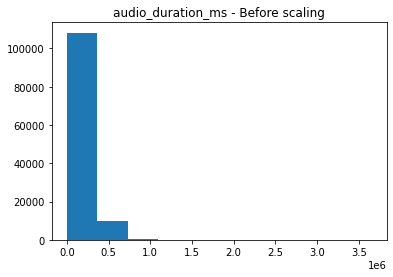

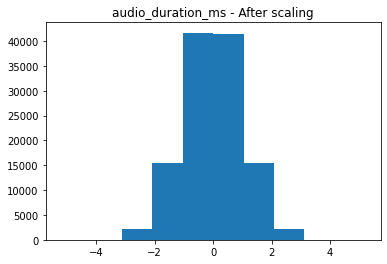

In [70]:
# SCALE
spotify_tracks = spotify_tracks.copy()

quantile_transformer = preprocessing.QuantileTransformer(random_state=0,n_quantiles=112, output_distribution='normal')

plt.hist(spotify_tracks["audio_duration_ms"])
plt.title('audio_duration_ms - Before scaling')
plt.show()


for el in spotify_tracks.columns:
    if el != 'track_genre':
        # We can't pass a 1D array to normalize()
        # We apply reshape 
        reshape = spotify_tracks[el].values.reshape(-1,1)
        spotify_tracks[el] = quantile_transformer.fit_transform(reshape)

plt.hist(spotify_tracks["audio_duration_ms"])
plt.title('audio_duration_ms - After scaling')
plt.show()

In [71]:
# NORMALIZE
spotify_tracks = spotify_tracks.copy()

print("Before Normalization: \n", spotify_tracks['audio_duration_ms'])

for el in spotify_tracks.columns:
    if el != 'track_genre':
    # We can't pass a 1D array to normalize()
    # We apply reshape 
        reshape = spotify_tracks[el].values.reshape(-1,1)
        spotify_tracks[el] = preprocessing.normalize([spotify_tracks[el]], norm='l2')[0]

print("After Normalization: \n", spotify_tracks['audio_duration_ms'])

Before Normalization: 
 0        -0.784219
1         0.024236
2        -0.796522
3        -0.593066
4        -0.017565
            ...   
118495    0.509098
118496   -0.231751
118497   -2.160920
118498    1.101438
118499    0.533786
Name: audio_duration_ms, Length: 118500, dtype: float64
After Normalization: 
 0        -0.002310
1         0.000071
2        -0.002346
3        -0.001747
4        -0.000052
            ...   
118495    0.001499
118496   -0.000683
118497   -0.006365
118498    0.003244
118499    0.001572
Name: audio_duration_ms, Length: 118500, dtype: float64


In [72]:
# SPLIT
spotify_tracks = spotify_tracks.copy()
y = spotify_tracks['track_genre']
X = spotify_tracks.drop('track_genre', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 112)

In [73]:
%%time

rfc_clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
rfc_clf.fit(X_train, y_train)

r = permutation_importance(rfc_clf, X, y, n_repeats=10, random_state=0)

# Dict to store features and their importance
less_important = {}

for i in r.importances_mean.argsort()[::-1]:
    less_important[spotify_tracks.columns[i]] = r.importances_mean[i]
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{r.importances_mean[i]:.3f}" f" +/- {r.importances_std[i]:.3f} " f"{spotify_tracks.columns[i]}")

0.105 +/- 0.001 audio_instrumentalness
0.074 +/- 0.001 year
0.068 +/- 0.001 audio_acousticness
0.065 +/- 0.000 timbre5
0.051 +/- 0.000 timbre0
0.050 +/- 0.000 timbre1
0.049 +/- 0.001 timbre3
0.044 +/- 0.000 track_popularity
0.042 +/- 0.000 timbre4
0.038 +/- 0.000 audio_valence
0.038 +/- 0.001 audio_duration_ms
0.034 +/- 0.000 timbre10
0.027 +/- 0.000 track_name
0.025 +/- 0.000 audio_energy
0.023 +/- 0.000 audio_danceability
0.020 +/- 0.000 timbre9
0.018 +/- 0.000 timbre2
0.016 +/- 0.000 timbre7
0.016 +/- 0.000 audio_tempo
0.013 +/- 0.000 audio_loudness
0.011 +/- 0.000 audio_speechiness
0.010 +/- 0.000 album_name
0.008 +/- 0.000 pitch1
0.008 +/- 0.000 timbre6
0.008 +/- 0.000 artist_name
0.007 +/- 0.000 track_explicit
0.006 +/- 0.000 pitch3
0.006 +/- 0.000 pitch0
0.006 +/- 0.000 month
0.006 +/- 0.000 timbre11
0.006 +/- 0.000 day
0.006 +/- 0.000 timbre8
0.005 +/- 0.000 pitch8
0.005 +/- 0.000 pitch10
0.005 +/- 0.000 pitch11
0.005 +/- 0.000 pitch5
0.004 +/- 0.000 audio_liveness
0.004 +/- 0.

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 112)

# Class names of the target
target_names = genres

In [75]:
%%time

dtc_parameter = {
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [2, 10, 25, 50, 100],
    'max_depth': [5, 10, 50, 100]}

dtc = GridSearchCV(tree.DecisionTreeClassifier(), dtc_parameter, n_jobs = -1) 
dtc.fit(X_train, y_train) 
dtc_best_params = dtc.best_params_
print("Best parameters:", dtc_best_params)

Best parameters: {'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 2}
CPU times: user 1min 8s, sys: 5.18 s, total: 1min 13s
Wall time: 1h 54min 57s


In [76]:
dtc_predicted = dtc.predict(X_test)
print("Confusion Matrix: \n", confusion_matrix(y_test, dtc_predicted), "\n")
print("Classification Report: \n", classification_report(y_test, dtc_predicted, target_names = target_names))

Confusion Matrix: 
 [[ 24   8   4 ...   0   0   6]
 [  5  28   2 ...   2   1   8]
 [  5   2  48 ...   0   1   0]
 ...
 [  7   2   1 ...  37   1   0]
 [  2   2   1 ...   2 134   0]
 [  6   9   2 ...   0   1  55]] 

Classification Report: 
                    precision    recall  f1-score   support

         acoustic       0.06      0.08      0.07       312
         afrobeat       0.07      0.11      0.08       262
         alt-rock       0.11      0.18      0.14       271
      alternative       0.08      0.12      0.09       299
          ambient       0.21      0.28      0.24       286
            anime       0.32      0.37      0.34       290
      black-metal       0.44      0.56      0.50       277
        bluegrass       0.13      0.18      0.15       296
            blues       0.07      0.12      0.09       253
        bossanova       0.36      0.49      0.41       264
           brazil       0.40      0.52      0.45       297
        breakbeat       0.10      0.15      0.12    

In [77]:
%%time

dtc_clf = tree.DecisionTreeClassifier(criterion = dtc_best_params['criterion'],
                                    min_samples_leaf = dtc_best_params['min_samples_leaf'],
                                    max_depth = dtc_best_params['max_depth'])

dtc_scores = cross_val_score(dtc_clf, X, y, cv=5, n_jobs=-1)
print("Max Accuracy:", "{:.2f}".format(max(dtc_scores)), " Mean Accuracy:", "{:.2f}".format(dtc_scores.mean()), "+/-", "{:.2f}".format(dtc_scores.std()*2))

TypeError: ignored

In [ ]:
%%time

# I avoided using the "rbf" kernel because trying it took too long to run (over an afternoon).
svm_parameters = {
    'kernel': ['linear'],
    'gamma': [1, 1e-1, 1e-2],
    'C': [100, 1000, 100000]}

svc = GridSearchCV(svm.SVC(), svm_parameters, n_jobs=-1)
svc.fit(X_train, y_train)  

svc_best_params = svc.best_params_
print("Best parameters:", svc_best_params)

In [ ]:
svc_predicted = svc.predict(X_test) 

print("Confusion Matrix: \n", confusion_matrix(y_test, svc_predicted), "\n")
print("Classification Report: \n", classification_report(y_test, svc_predicted, target_names = target_names))

In [ ]:
%%time

svc_clf = svm.SVC(kernel = svc_best_params['kernel'], gamma = svc_best_params['gamma'], C = svc_best_params['C'])

svc_scores = cross_val_score(svc_clf, X, y, cv=5, n_jobs=-1)

print("Max Accuracy:", "{:.2f}".format(max(svc_scores)), " Mean Accuracy:", "{:.2f}".format(svc_scores.mean()), "+/-", "{:.2f}".format(svc_scores.std()*2))

In [ ]:
%%time

parameter_RF = {
    'min_samples_leaf': [1, 3],
    'n_estimators': [500, 1000],
    'max_depth': [50, 100]}

rf = GridSearchCV(RandomForestClassifier(), parameter_RF, n_jobs=-1)
rf.fit(X_train, y_train) 

rf_best_params = rf.best_params_
print("Best parameters:", rf_best_params)

In [ ]:
rf_predicted = rf.predict(X_test)

print("Confusion Matrix: \n", confusion_matrix(y_test, rf_predicted), "\n")
print("Classification Report: \n", classification_report(y_test, rf_predicted, target_names=target_names))

In [ ]:
%%time

rf_clf = RandomForestClassifier(n_estimators = rf_best_params['n_estimators'], 
                                min_samples_leaf = rf_best_params['min_samples_leaf'],
                                max_depth = rf_best_params['max_depth'])

rf_scores = cross_val_score(rf_clf, X, y, cv=5, n_jobs=-1)

print("Max Accuracy: ", "{:.2f}".format(max(rf_scores)), " Mean Accuracy:", "{:.2f}".format(rf_scores.mean()), "+/-", "{:.2f}".format(rf_scores.std()*2))

In [ ]:
%%time

rf_clf = RandomForestClassifier(n_estimators = rf_best_params['n_estimators'], 
                                min_samples_leaf = rf_best_params['min_samples_leaf'],
                                max_depth = rf_best_params['max_depth'])

rf_scores = cross_val_score(rf_clf, X, y, cv=5, n_jobs=-1)

print("Max Accuracy: ", "{:.2f}".format(max(rf_scores)), " Mean Accuracy:", "{:.2f}".format(rf_scores.mean()), "+/-", "{:.2f}".format(rf_scores.std()*2))
%%time

parameter_MLP = {
    'hidden_layer_sizes' : [(10, 5, 2), (20, 10, 5), (30, 15, 10)],
    'alpha' : [1e-2, 1e-3, 1e-4, 1e-5],
    'solver' : ['lbfgs', 'sgd', 'adam'],
    'tol': [1e-2, 1e-3, 1e-4]}

mlpn = RandomizedSearchCV(MLPClassifier(), parameter_MLP, n_jobs=-1)
mlpn.fit(X_train, y_train)

mlp_best_params = mlpn.best_params_
print("Best parameters:", mlp_best_params)

In [ ]:
mpl_predicted = mlpn.predict(X_test)

print("Confusion Matrix: \n", confusion_matrix(y_test, mpl_predicted), "\n")
print("Classification Report: \n", classification_report(y_test, mpl_predicted, target_names = target_names))

In [ ]:
%%time

mlpn_clf = MLPClassifier(solver = mlp_best_params['solver'],
                    hidden_layer_sizes = mlp_best_params['hidden_layer_sizes'],
                    alpha = mlp_best_params['alpha'],
                    tol = mlp_best_params['tol'])

mpl_scores = cross_val_score(mlpn_clf, X, y, cv=5, n_jobs=-1)
print("Max Accuracy: ", "{:.2f}".format(max(mpl_scores)), " Mean Accuracy:", "{:.2f}".format(mpl_scores.mean()), "+/-", "{:.2f}".format(mpl_scores.std()*2))